<a href="https://colab.research.google.com/github/paduapires/aapg_ice/blob/main/01_Regressao_multilinear_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.linalg as la

# Regressão multilinear

Um dos modelos mais simples e flexíveis para a predição de variáveis contínuas é o modelo de regressão multilinear:

$$y_i = w_0 + w_1 x_{i1} + w_2 x_{i2} + \cdots + w_M x_{iM} = \vec{x}_i\cdot \vec{w}
$$

Onde $y_i$ é a variável que queremos prever (*label*) para o $i$-ésimo exemplo, a partir das $M$ variáveis conhecidas (atributos, *features*) $x_{ij}$ ($j=1,2,\dots,M$).

Cada exemplo é representado pelo seu vetor de atributos $\vec{x}_i$ e é comum armazenar todo o conjuto de $N$ exemplos em uma matriz $X$  ($N\times M+1$) da forma:

$$X = \begin{bmatrix} \vec{x}_1^T \\ \vec{x}_2^T \\ \vdots \\ \vec{x}_M^T
\end{bmatrix} = \begin{bmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1M} \\
1 & x_{21} & x_{22} & \cdots & x_{2M} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{N1} & x_{N2} & \cdots & x_{NM} \\
\end{bmatrix}
$$

onde é comum adicionar uma coluna constante de valor $1$ aos atributos. Dessa forma, o modelo de regressão multilinear se escreve como uma única equação matricial:

$$
X\vec{w} = \vec{y},
$$

cuja solução de mínimos quadrados é dada pelas equações normais:

$$\begin{align}
X^TX\vec{w} = &X^T\vec{y}\\
\vec{w} = & \left(X^TX\right)^{-1}X^T\vec{y}
\end{align}
$$

## Carregamento de dados

O arquivo `https://github.com/paduapires/aapg_ice/raw/main/silic_anonimo.xlsx` contém dados de perfis de poços com medidas de **z**, **gr**, **rho**, **nphi**, **dt_p**, **facies** e **dt_s**.

In [38]:
# Construct the raw file URL for the Excel file on GitHub
excel_url = 'https://github.com/paduapires/aapg_ice/raw/main/silic_anonimo.xlsx'

# Use pandas to read the Excel file directly from the raw URL
df = pd.read_excel(excel_url, engine='openpyxl')
display(df.head())

HTTPError: HTTP Error 404: Not Found

In [20]:
# eliminando linhas com dados incompletos
df = df.dropna() # SEU CODIGO AQUI para eliminar linhas com NaN
df.sample(10)

,poco,z,gr,rho,nphi,dt_p,dt_s,facies
27333,well_1,3835.450918,94.964256,2.335259,19.183961,82.946951,149.291374,ARENITO
31381,well_1,4452.366118,148.931946,2.462696,19.075945,75.550556,132.760980,FOLHELHO
13622,well_0,3970.934572,71.170746,2.413346,30.334547,97.829366,175.509967,FOLHELHO
13641,well_0,3973.830172,64.498993,2.453059,29.469195,91.425626,175.158816,FOLHELHO
32308,well_1,4593.640918,129.584717,2.470971,5.398690,61.508868,111.564485,ARENITO
27343,well_1,3836.974918,101.976387,2.324585,18.057757,86.154579,151.665267,ARENITO
20290,well_1,2762.097718,88.863998,2.180518,35.415891,117.040269,277.396900,ARENITO
17457,well_0,4555.388572,29.318180,2.547503,10.812960,61.814705,117.492487,CALCARENITO
29526,well_1,4169.664118,101.666481,2.449644,9.772984,73.017544,133.803130,ARENITO
30177,well_1,4268.876518,98.320030,2.413196,10.453420,75.746759,134.887233,ARENITO


## One hot enconding

Uma das formas de transformar a informação textual da coluna `facies` em uma informação numérica é através do dito *one hot encoding*, implementado pela função `pd.get_dummies`. Esse esquema cria uma nova coluna para cada valor categórico distinto, com valores $0$ ou $1$, de acordo com o valor de cada linha do conjunto de dados.

Uma das opções de `pd.get_dummies` é o argumento `drop_first`, que elimina a primeira coluna de *dummies*, uma vez que ela pode ser inferida a partir das outras. Nesta aplicação, utilize `drop_first=False`.

In [21]:
one_hot = pd.get_dummies(df['facies'],drop_first=False)
display(one_hot.sample(5))
one_hot.sum() # contando o numero de exemplos de cada facies

,ANIDRITA,AREIA,ARENITO,CALCARENITO,CALCILUTITO,DOLOMITO,FOLHELHO,MARGA,SILTITO
11708,False,False,False,False,False,False,True,False,False
29968,False,False,True,False,False,False,False,False,False
27881,False,False,True,False,False,False,False,False,False
28640,False,False,True,False,False,False,False,False,False
28443,False,False,True,False,False,False,False,False,False


,0
ANIDRITA,114
AREIA,7
ARENITO,11566
CALCARENITO,1091
CALCILUTITO,708
DOLOMITO,69
FOLHELHO,11038
MARGA,2850
SILTITO,587


 A classe `'AREIA'` tem muito poucos pontos. Vamos incorporar estes pontos na classe `'ARENITO'`:

In [22]:
df.loc[df['facies']=='AREIA','facies'] = 'ARENITO' # indexacao de DataFrame para mutacao eh chatinho...
one_hot = pd.get_dummies(df['facies'],drop_first=False)
one_hot.sum() # contando o numero de exemplos de cada facies

,0
ANIDRITA,114
ARENITO,11573
CALCARENITO,1091
CALCILUTITO,708
DOLOMITO,69
FOLHELHO,11038
MARGA,2850
SILTITO,587


In [23]:
one_hot_arr = one_hot.values.astype(bool)
litos = list(one_hot.columns)
cmap = {'ANIDRITA':'magenta', 'ARENITO':'xkcd:goldenrod', 'CALCARENITO':'cyan',
        'CALCILUTITO':'xkcd:dark blue', 'DOLOMITO':'purple', 'FOLHELHO':'green',
        'MARGA':'xkcd:greenish blue', 'SILTITO':'xkcd:reddish orange'}

Vamos considerar o poco `well_0` como nosso conjunto de treino, e usar o `well_1` como teste cego

In [24]:
mask_treino = df['poco']=='well_0'
mask_teste  = ~mask_treino

df_treino = df[mask_treino]
df_teste  = df[mask_teste ]

one_hot_treino = one_hot_arr[mask_treino]
one_hot_teste  = one_hot_arr[mask_teste ]

Cada atributo é correlacionado com o **dt_s** de alguma forma. Observe o pairplot abaixo:

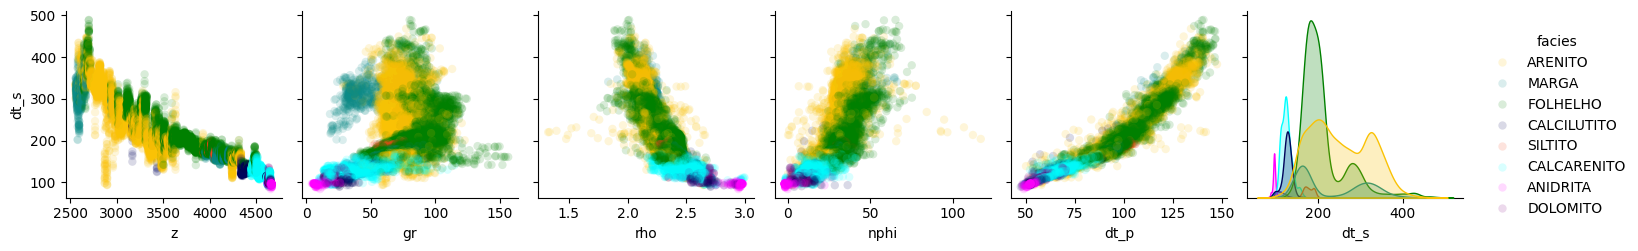

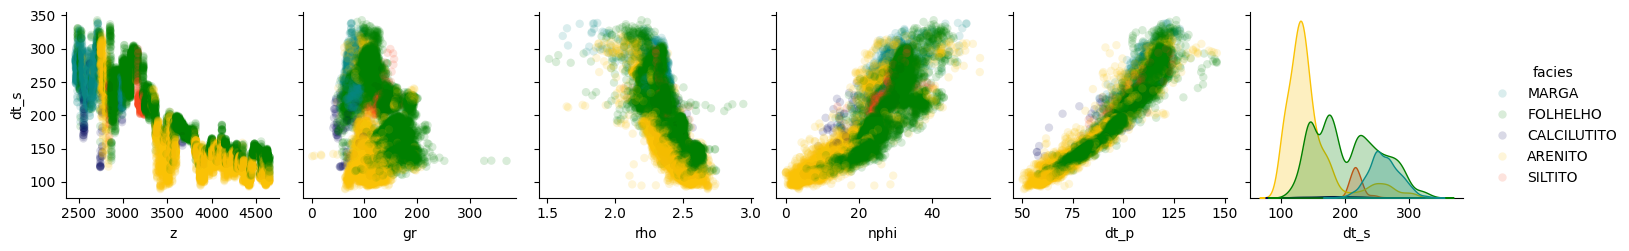

In [25]:
sns.pairplot(data=df_treino,x_vars=df.columns[1:-1],y_vars=['dt_s'], hue='facies',
             plot_kws={'alpha':0.15,'edgecolor':'none'},palette=cmap)
sns.pairplot(data=df_teste ,x_vars=df.columns[1:-1],y_vars=['dt_s'], hue='facies',
             plot_kws={'alpha':0.15,'edgecolor':'none'},palette=cmap)
plt.show() # demora uns 5s

A função abaixo vai ser útil para fazer os plots:

In [26]:
def per_facies_scatter(x,y,one_hot_arr,labels=None,xlabel=None,ylabel=None,
                       suptitle='',marker='.',linestyle='',cmap=cmap,*args,**kwargs):
    n_pts,n_groups = one_hot_arr.shape
    if labels is None: labels = ['']*n_groups
    nlin = int(np.floor(np.sqrt(n_groups+1)))
    ncol = int(np.ceil(n_groups/nlin))
    fig,axs = plt.subplots(nlin,ncol,sharex='all',sharey='all',
                           gridspec_kw={'wspace':0,'hspace':0})
    xy = np.concatenate((x.ravel(),y.ravel()))
    mM = xy.min(),xy.max()
    labels = ['Tudo'] + labels
    masks = np.column_stack((np.ones(n_pts,dtype=bool),one_hot_arr.astype(bool)))
    for i,(ax,mask,label) in enumerate(zip(axs.flat,masks.T,labels)):
        ax.plot(mM,mM,'k--'), ax.grid()
        if not mask.any(): #Se nao tem a classe, pula
            continue
        x_mask,y_mask = x[mask],y[mask]
        MSE = ((x_mask-y_mask)**2).mean()
        RMSE = np.sqrt(MSE)
        R2 = 1 - MSE/y.var()
        cor = cmap.get(label,'C0')
        ax.plot(x_mask,y_mask,*args,marker=marker,linestyle=linestyle,color=cor,
                label=f'{label}\n{RMSE=:.2f}\n{R2=:.3f}',**kwargs)
        ax.legend(fontsize=8)
    if xlabel:
        axs[-1     ,ncol//2].set_xlabel(xlabel)
    if ylabel:
        axs[nlin//2,0      ].set_ylabel(ylabel)
    fig.suptitle(suptitle)
    plt.tight_layout()
    return fig,axs


## Seleção dos atributos

A proposta é utilizar os perfis medidos para **prever** o valor de **dt_s** (para prever este valor em um outro poço análogo, onde não foi corrido este perfil, por exemplo).

In [27]:
features = ['rho','nphi','dt_p'] # Sera que vale a pena usar 'z'? E 'nphi'?
label = 'dt_s'

X_treino = df_treino[features].values # transformando em np.array
X_teste  = df_teste[features].values

y_treino = df_treino[label].values
y_teste  = df_teste[label].values

### Modelo de grau 1

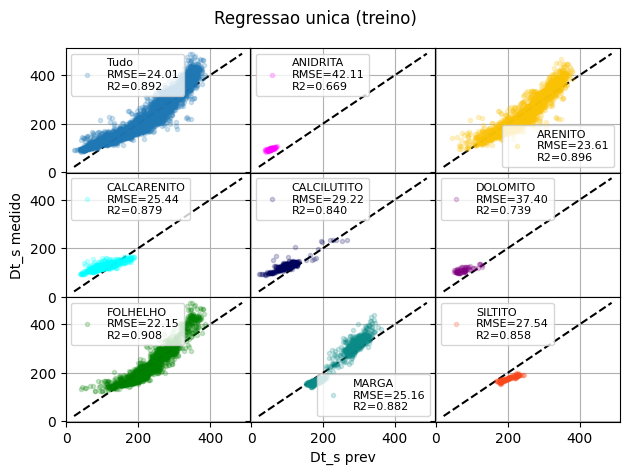

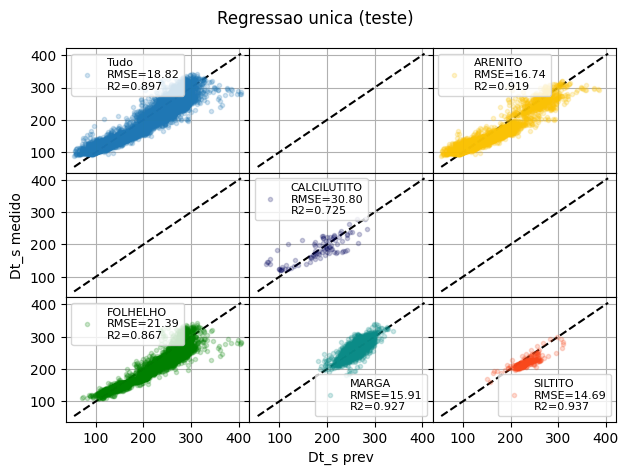

In [28]:
X1_treino = np.column_stack((np.ones(X_treino.shape[0]),X_treino)) # Adicionando a coluna de 1
X1_teste  = np.column_stack((np.ones(X_teste.shape[0] ),X_teste )) # Adicionando a coluna de 1

w1 = la.lstsq(X1_treino,y_treino)[0] # SEU CODIGO AQUI para treinar o modelo
y_hat1_treino = X1_treino@w1 # SEU CODIGO AQUI para fazer a inferencia nos dados de treino

y_hat1_teste = X1_teste@w1 # SEU CODIGO AQUI para fazer a inferencia nos dados de teste

alp = 0.2 # opacidade
xlabel = 'Dt_s prev'
ylabel = 'Dt_s medido'

per_facies_scatter(y_hat1_treino, y_treino, one_hot_treino, litos,
                   alpha=alp, xlabel=xlabel, ylabel=ylabel,
                   suptitle='Regressao unica (treino)')
per_facies_scatter(y_hat1_teste, y_teste, one_hot_teste, litos,
                   alpha=alp, xlabel=xlabel, ylabel=ylabel,
                   suptitle='Regressao unica (teste)')

plt.show()

## Criação de novas features

Conhecido como *feature egineering*. Vamos criar atributos quadráticos para obter um regressor mais flexível (menos viés):

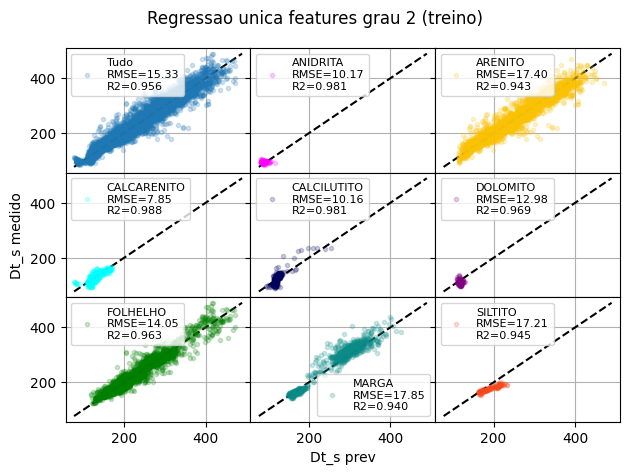

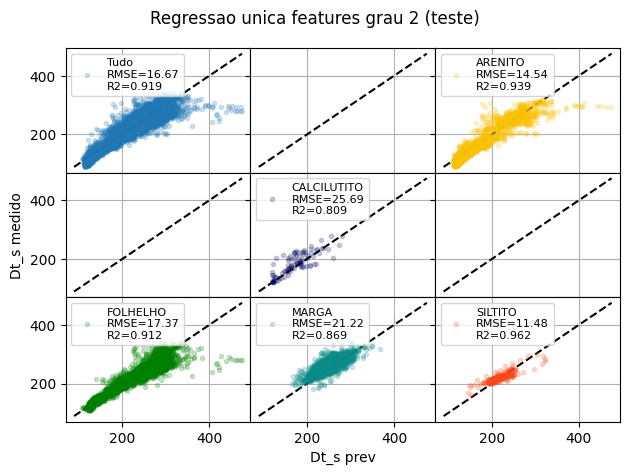

In [29]:
X2_treino = [] # inicializando
X2_teste = [] # inicializando
ncols = X1_treino.shape[1]
for i in range(ncols):
    for j in range(i,ncols):
        X2_treino.append(X1_treino[:,i]*X1_treino[:,j])
        X2_teste.append(X1_teste[:,i]*X1_teste[:,j])

X2_treino = np.column_stack(X2_treino) # 1, rho, nphi, dt_p, rho**2, rho*nphi, rho*dt_p, nphi**2, nphi*dt_p, dt_p**2
X2_teste  = np.column_stack(X2_teste)  # 1, rho, nphi, dt_p, rho**2, rho*nphi, rho*dt_p, nphi**2, nphi*dt_p, dt_p**2

w2 = la.lstsq(X2_treino,y_treino)[0] # SEU CODIGO AQUI para treinar o modelo
y_hat2_treino = X2_treino@w2  # SEU CODIGO AQUI para fazer a inferencia nos dados de treino

y_hat2_teste  = X2_teste@w2  # SEU CODIGO AQUI para fazer a inferencia nos dados de teste

per_facies_scatter(y_hat2_treino, y_treino, one_hot_treino, litos,
                   alpha=alp, xlabel=xlabel, ylabel=ylabel,
                   suptitle='Regressao unica features grau 2 (treino)')
per_facies_scatter(y_hat2_teste, y_teste, one_hot_teste, litos,
                   alpha=alp, xlabel=xlabel, ylabel=ylabel,
                   suptitle='Regressao unica features grau 2 (teste)')
plt.show()

## Separação por litologia

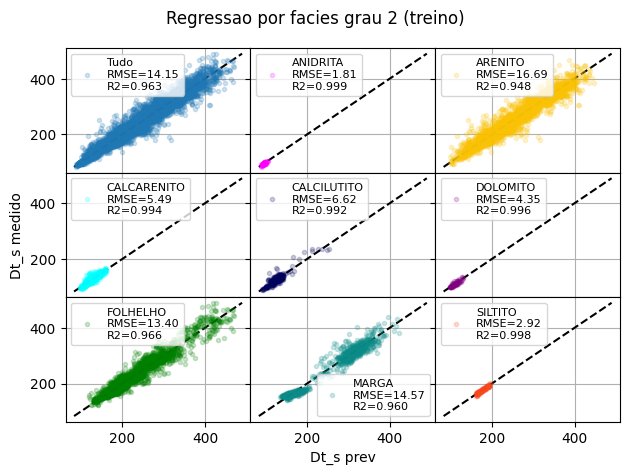

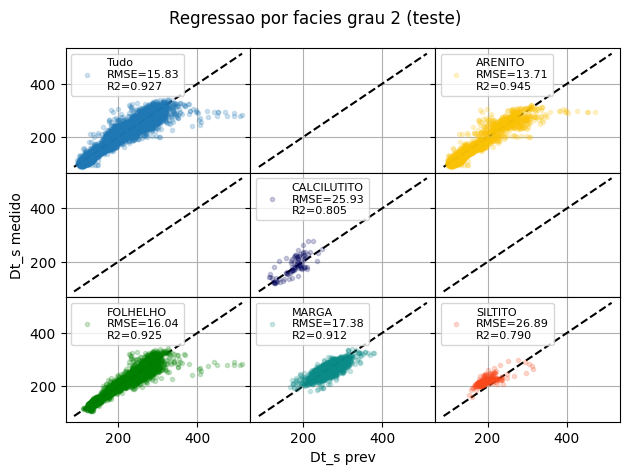

In [30]:
#                     n_pts, n_litos, n_feat                    n_pts, n_litos, n_feat
X3_treino = X2_treino[ :   ,  None  ,  :   ]*one_hot_treino[ :   ,  :     ,  None ] # broadcasting
X3_teste  =  X2_teste[ :   ,  None  ,  :   ]* one_hot_teste[ :   ,  :     ,  None ] # broadcasting

#                                          n_pts, n_feat*n_litos
X3_treino = X3_treino.reshape(X3_treino.shape[0], -1)
X3_teste  = X3_teste.reshape( X3_teste.shape[0] , -1)

w3 = la.lstsq(X3_treino,y_treino)[0] # SEU CODIGO AQUI para treinar o modelo
y_hat3_treino = X3_treino@w3 # SEU CODIGO AQUI para fazer a inferencia nos dados de treino

y_hat3_teste = X3_teste@w3 # SEU CODIGO AQUI para fazer a inferencia nos dados de teste

per_facies_scatter(y_hat3_treino, y_treino, one_hot_treino, litos,
                   alpha=alp, xlabel=xlabel, ylabel=ylabel,
                   suptitle='Regressao por facies grau 2 (treino)')
per_facies_scatter(y_hat3_teste, y_teste, one_hot_teste, litos,
                   alpha=alp, xlabel=xlabel, ylabel=ylabel,
                   suptitle='Regressao por facies grau 2 (teste)')
plt.show()

## Usando diretamente o `sklearn`

In [31]:
import sklearn.preprocessing as skp
import sklearn.linear_model as skl
import sklearn.metrics as skm

Para o treino, usamos os métodos `.fit()`, ou `.fit_transform()`:

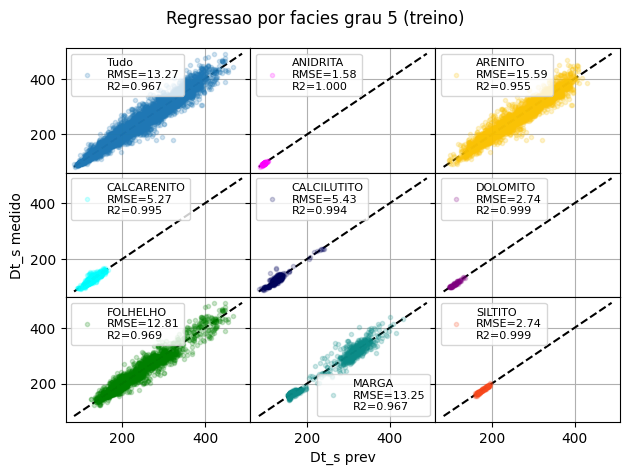

In [36]:
encoder = skp.OneHotEncoder(sparse_output=False) # instanciando o objeto
#encoder.fit(df_treino[['facies']]) # parametrizando o encoder
#one_hot_treino = encoder.transform(df_treino[['facies']]) # usando o encoder ja parametrizado
one_hot_treino = encoder.fit_transform(df_treino[['facies']]) # equivalente às duas linhas anteriores

poly = skp.PolynomialFeatures(degree=5) # instanciando o objeto
#poly.fit(X_treino) # parametrizando
#X_poly_treino = poly.transform(X_treino) # usando
X_poly_treino = poly.fit_transform(X_treino) # equivalente às duas linhas anteriores

X_tudo_treino = X_poly_treino[:,None,:] * one_hot_treino[:,:,None]
X_tudo_treino = X_tudo_treino.reshape(len(X_tudo_treino),-1)

model = skl.LinearRegression(fit_intercept=False) # instanciando o objeto. Ja tem a coluna de 1 nas features, entao nao precisa de intercept
model.fit(X_tudo_treino,y_treino) # treinando os parametros
y_hat4_treino = model.predict(X_tudo_treino) # usando os parametros ja treinados

per_facies_scatter(y_hat4_treino, y_treino, one_hot_treino, litos,
                   alpha=alp, xlabel=xlabel, ylabel=ylabel,
                   suptitle=f'Regressao por facies grau {poly.degree} (treino)')
plt.show()

Para a inferência, usamos somente `.transform()` para as transformações e `.predict()` para o modelo.

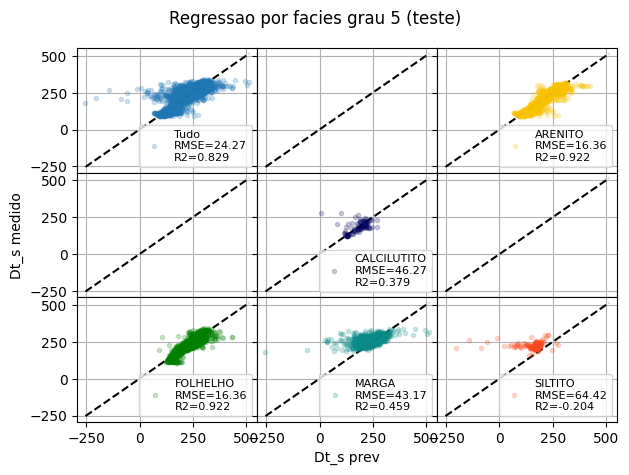

In [37]:
one_hot_teste = encoder.transform(df_teste[['facies']]) # usando as transformacoes parametrizadas no TREINO

X_poly_teste = poly.transform(X_teste) # usando as transformacoes parametrizadas no TREINO

X_tudo_teste = X_poly_teste[:,None,:] * one_hot_teste[:,:,None]
X_tudo_teste = X_tudo_teste.reshape(len(X_tudo_teste),-1)

y_hat4_teste = model.predict(X_tudo_teste) # usando os parametros ja treinados

per_facies_scatter(y_hat4_teste, y_teste, one_hot_teste, litos,
                   alpha=alp, xlabel=xlabel, ylabel=ylabel,
                   suptitle=f'Regressao por facies grau {poly.degree} (teste)')
plt.show()

Os parâmetros do modelo estão disponíveis nos atributos `model.coef_` e `model.intercept_` (se `fit_intercept=True`):

In [34]:
print(w3-model.coef_) # Devem ser iguais

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


Podemos quantificar a qualidade do modelo através de diversas métricas disponíveis no módulo `sklearn.metrics`:

In [35]:
print('MSE  (treino):',skm.mean_squared_error(y_treino,y_hat4_treino))
print('MSE  (teste) :',skm.mean_squared_error(y_teste ,y_hat4_teste ))
print()
print('RMSE (treino):',np.sqrt(skm.mean_squared_error(y_treino,y_hat4_treino)))
print('RMSE (teste) :',np.sqrt(skm.mean_squared_error(y_teste ,y_hat4_teste )))
print()
print('MAE  (treino):',skm.mean_absolute_error(y_treino,y_hat4_treino))
print('MAE  (teste) :',skm.mean_absolute_error(y_teste ,y_hat4_teste ))
print()
print('R2   (treino):',skm.r2_score(y_treino,y_hat4_treino))
print('R2   (teste) :',skm.r2_score(y_teste ,y_hat4_teste ))


MSE  (treino): 200.18792980324702
MSE  (teste) : 250.56877455536207

RMSE (treino): 14.14877838554435
RMSE (teste) : 15.829364313053196

MAE  (treino): 9.482428833021945
MAE  (teste) : 10.347727357116012

R2   (treino): 0.9625789919911564
R2   (teste) : 0.9272983415832539
